In [212]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [213]:
CONFIG = {
    "seed": 42,
    "img_size": 512,
    "model_name": "tf_efficientnet_b0_ns",
    "num_classes": 5,
    "valid_batch_size": 64,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [214]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [215]:
ROOT_DIR = '/kaggle/input/UBC-OCEAN'
TEST_DIR = '/kaggle/input/UBC-OCEAN/test_thumbnails'
ALT_TEST_DIR = '/kaggle/input/UBC-OCEAN/test_images'
TRAIN_DIR = '/kaggle/input/UBC-OCEAN/train_thumbnails'


In [220]:
class UBCDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df['label'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [221]:
data_transforms = {
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

In [222]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [223]:
class UBCModel(nn.Module):
    def __init__(self, model_name, num_classes, pretrained=False, checkpoint_path=None):
        super(UBCModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.linear(pooled_features)
        return output



# Valid

In [184]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}_thumbnail.png"
#    return f"{TRAIN_DIR}/{image_id}.png"

In [185]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.png"))

In [186]:
df = pd.read_csv(f"{ROOT_DIR}/train.csv")
df['file_path'] = df['image_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

,image_id,label,image_width,image_height,is_tma,file_path
0,4,HGSC,23785,20008,False,/kaggle/input/UBC-OCEAN/train_thumbnails/4_thu...
1,66,LGSC,48871,48195,False,/kaggle/input/UBC-OCEAN/train_thumbnails/66_th...
2,281,LGSC,42309,15545,False,/kaggle/input/UBC-OCEAN/train_thumbnails/281_t...
3,286,EC,37204,30020,False,/kaggle/input/UBC-OCEAN/train_thumbnails/286_t...
4,431,HGSC,39991,40943,False,/kaggle/input/UBC-OCEAN/train_thumbnails/431_t...
...,...,...,...,...,...,...
508,65022,LGSC,53355,46675,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65022...
509,65094,MC,55042,45080,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65094...
510,65300,HGSC,75860,27503,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65300...
511,65371,HGSC,42551,41800,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65371...


In [187]:
from sklearn.model_selection import train_test_split

# Split the info_df into train and validation sets (20% for validation)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Selecting the relevant columns for the validation set to match the structure of train (1).csv
val_df = val_df[['image_id', 'image_width','image_height', 'file_path','label' ]]

# Save the validation set to a CSV file
val_df=val_df.sort_values('image_id')
val_df.to_csv('validation_set.csv', index=False)
vdf = pd.read_csv(f"/kaggle/working/validation_set.csv")

In [188]:
vdf

,image_id,image_width,image_height,file_path,label
0,4,23785,20008,/kaggle/input/UBC-OCEAN/train_thumbnails/4_thu...,HGSC
1,281,42309,15545,/kaggle/input/UBC-OCEAN/train_thumbnails/281_t...,LGSC
2,1101,26306,18403,/kaggle/input/UBC-OCEAN/train_thumbnails/1101_...,HGSC
3,1252,60420,27480,/kaggle/input/UBC-OCEAN/train_thumbnails/1252_...,HGSC
4,1289,43940,26785,/kaggle/input/UBC-OCEAN/train_thumbnails/1289_...,HGSC
...,...,...,...,...,...
98,64111,15549,8129,/kaggle/input/UBC-OCEAN/train_thumbnails/64111...,HGSC
99,64188,77833,30683,/kaggle/input/UBC-OCEAN/train_thumbnails/64188...,HGSC
100,64629,25480,14920,/kaggle/input/UBC-OCEAN/train_thumbnails/64629...,HGSC
101,64950,70968,37971,/kaggle/input/UBC-OCEAN/train_thumbnails/64950...,HGSC


In [191]:
vdf['label']=0

In [192]:
test_dataset = UBCDataset(vdf, transforms=data_transforms["valid"])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'], 
                          num_workers=2, shuffle=False, pin_memory=True)

In [193]:
df_sub=val_df[['image_id', 'label']]
df_sub.to_csv('val_labels.csv', index=False)
df_sub=pd.read_csv('/kaggle/working/val_labels.csv')
df_sub

,image_id,label
0,4,HGSC
1,281,LGSC
2,1101,HGSC
3,1252,HGSC
4,1289,HGSC
...,...,...
98,64111,HGSC
99,64188,HGSC
100,64629,HGSC
101,64950,HGSC


In [197]:
RESULTs=np.array([[]]*len(df_sub))
for i in range(10):
    model = UBCModel(CONFIG['model_name'], CONFIG['num_classes'])#, checkpoint_path=CONFIG['checkpoint_path']
    model.to(CONFIG['device'])
    model.load_state_dict(torch.load(f'/kaggle/input/weight/Best_EfficientNet_b0_Model_{i}.pth'))
    preds = []
    with torch.no_grad():
        bar = tqdm(enumerate(test_loader), total=len(test_loader))
        for step, data in bar:        
            images = data['image'].to(CONFIG["device"], dtype=torch.float)        
            batch_size = images.size(0)
            outputs = model(images)
            _, predicted = torch.max(model.softmax(outputs), 1)
            preds.append( predicted.detach().cpu().numpy() )
    preds = np.concatenate(preds).flatten()
    preds = np.array(preds)
    preds = preds.reshape(-1,1)
    RESULTs=np.append(RESULTs,preds,axis=1)


100%|██████████| 2/2 [00:11<00:00,  5.56s/it]


In [198]:
RESULTs=RESULTs.astype(int)
RESULT=[]
for line in RESULTs:
    #print(np.argmax(np.bincount(line)))
    RESULT.append(np.argmax(np.bincount(line)))

In [199]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}_thumbnail.png"
#    return f"{TRAIN_DIR}/{image_id}.png"

In [200]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.png"))
df = pd.read_csv(f"{ROOT_DIR}/train.csv")
df['file_path'] = df['image_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])

with open("label_encoder.pkl", "wb") as fp:
    joblib.dump(encoder, fp)

In [201]:
pred_labels = encoder.inverse_transform(RESULT)

In [202]:
df_sub["label"] = pred_labels
df_sub.to_csv("submission.csv", index=False)

In [203]:
pred_labels

array(['HGSC', 'HGSC', 'HGSC', 'HGSC', 'EC', 'CC', 'HGSC', 'HGSC', 'HGSC',
       'CC', 'HGSC', 'HGSC', 'CC', 'EC', 'CC', 'LGSC', 'HGSC', 'HGSC',
       'HGSC', 'LGSC', 'CC', 'LGSC', 'EC', 'HGSC', 'HGSC', 'HGSC', 'LGSC',
       'HGSC', 'CC', 'HGSC', 'EC', 'HGSC', 'CC', 'HGSC', 'CC', 'HGSC',
       'HGSC', 'LGSC', 'EC', 'CC', 'EC', 'HGSC', 'LGSC', 'HGSC', 'HGSC',
       'HGSC', 'LGSC', 'EC', 'HGSC', 'CC', 'HGSC', 'HGSC', 'CC', 'CC',
       'HGSC', 'MC', 'CC', 'MC', 'EC', 'EC', 'CC', 'EC', 'CC', 'HGSC',
       'HGSC', 'MC', 'LGSC', 'MC', 'MC', 'HGSC', 'HGSC', 'LGSC', 'EC',
       'MC', 'CC', 'EC', 'CC', 'CC', 'HGSC', 'CC', 'EC', 'EC', 'EC',
       'HGSC', 'EC', 'EC', 'EC', 'CC', 'HGSC', 'MC', 'HGSC', 'MC', 'HGSC',
       'HGSC', 'HGSC', 'HGSC', 'HGSC', 'EC', 'HGSC', 'HGSC', 'HGSC',
       'HGSC', 'LGSC'], dtype=object)

In [206]:
a=pd.read_csv('/kaggle/working/val_labels.csv')
b=pd.read_csv('/kaggle/working/submission.csv')

In [208]:
b

,image_id,label
0,4,HGSC
1,281,HGSC
2,1101,HGSC
3,1252,HGSC
4,1289,EC
...,...,...
98,64111,HGSC
99,64188,HGSC
100,64629,HGSC
101,64950,HGSC


In [210]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# Load the data
val_labels_path = '/kaggle/working/val_labels.csv'
submission_path = '/kaggle/working/submission.csv'

val_labels_df = pd.read_csv(val_labels_path)
submission_df = pd.read_csv(submission_path)

# Ensure that both dataframes have the same order of samples
# Assuming that the order of samples in submission is the same as in val_labels
# and that there is a column named 'label' in both dataframes representing the classification

# Check if the dataframes have the same length
if len(val_labels_df) != len(submission_df):
    raise ValueError("The number of samples in the prediction and ground truth dataframes do not match.")

# Calculate accuracy and F1 score
accuracy = accuracy_score(val_labels_df['label'], submission_df['label'])
f1 = f1_score(val_labels_df['label'], submission_df['label'], average='weighted')

accuracy, f1



(0.8737864077669902, 0.873464610837613)

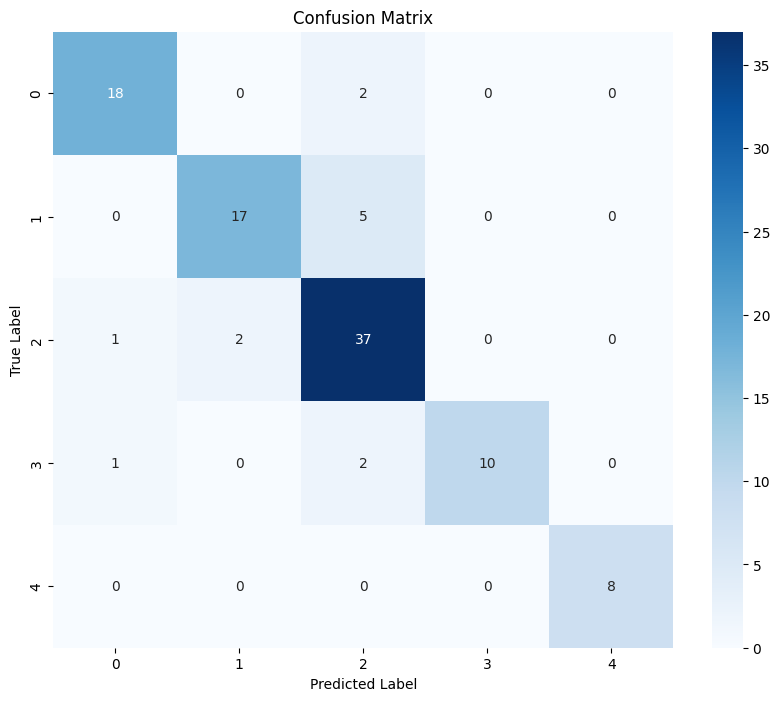

In [211]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(val_labels_df['label'], submission_df['label'])

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
